##Load the Kaggle Data

In [1]:


!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!pip install --upgrade --force-reinstall -- kaggle
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content/


kaggle.json
Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/2b/26e37a4b034800c960a00c4e1b3d9ca5d7014e983e6e729e33ea2f36426c/certifi-2020.4.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1a/70/1935c770cb3be6e3a8b78ced23d7e0f3b187f5cbfab4749523ed65d7c9b1/requests-2.23.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4a/1c/6359be64e8301b84160f6f6f7936bbfaaa5e9a4eab6cbc681db07600b949/tqdm-4.45.0-py2.py3-none-any.whl
Processing /root/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f/python_slugify-4.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/eb/1f97cb97bfc2390a276969c

 98% 801M/814M [00:04<00:00, 110MB/s]
100% 814M/814M [00:04<00:00, 185MB/s]


In [0]:
import os
os.chdir('../content/')  #change dir
!unzip -q dogs-vs-cats-redux-kernels-edition.zip   


In [0]:
!unzip -q test.zip   #unzip data in train/
!unzip -q train.zip   #unzip data in train/

##Split the data : Train/Validation

In [0]:
!bash -c 'mv ../content/train/cat.{0..12499}.jpg /content/Cat'

In [0]:
!bash -c 'mv ../content/train/dog.{0..12499}.jpg /content/Dog'

In [0]:
!bash -c 'mv ../content/Cat/cat.{0..999}.jpg /content/Val_cat'
!bash -c 'mv ../content/Dog/dog.{0..999}.jpg /content/Val_dog'

##Imports

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
num_cats_tr = len(os.listdir('/content/Tr/Cat'))
num_dogs_tr = len(os.listdir('/content/Tr/Dog'))

num_cats_val = len(os.listdir('/content/Vl/Val_cat'))
num_dogs_val = len(os.listdir('/content/Vl/Val_dog'))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 11500
total training dog images: 11500
total validation cat images: 1000
total validation dog images: 1000
--
Total training images: 23000
Total validation images: 2000


##Data Augmentation

In [0]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [0]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [12]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory='../content/Tr',
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 23000 images belonging to 2 classes.


In [13]:
train_data_gen.class_indices

{'Cat': 0, 'Dog': 1}

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

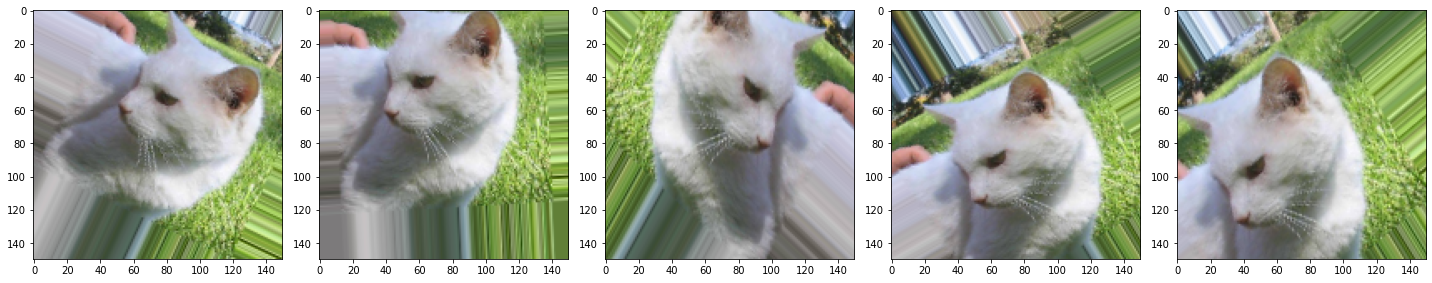

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory='../content/Vl',
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen) 

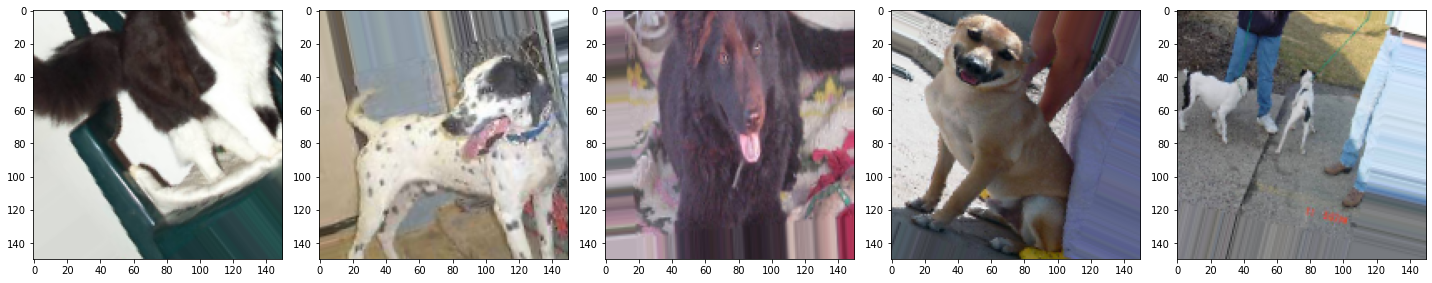

In [18]:
plotImages(sample_training_images[:5])  # Plot images 0-4

##Modeling

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [22]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/10
230/230 [==============================] - 160s 694ms/step - loss: 0.6787 - accuracy: 0.5684 - val_loss: 0.7043 - val_accuracy: 0.5620
Epoch 2/10
230/230 [==============================] - 157s 684ms/step - loss: 0.6083 - accuracy: 0.6653 - val_loss: 0.5224 - val_accuracy: 0.7455
Epoch 3/10
230/230 [==============================] - 157s 682ms/step - loss: 0.5607 - accuracy: 0.7090 - val_loss: 0.4990 - val_accuracy: 0.7510
Epoch 4/10
230/230 [==============================] - 156s 680ms/step - loss: 0.5295 - accuracy: 0.7340 - val_loss: 0.4389 - val_accuracy: 0.7895
Epoch 5/10
230/230 [==============================] - 156s 680ms/step - loss: 0.4956 - accuracy: 0.7595 - val_loss: 0.4008 - val_accuracy: 0.8155
Epoch 6/10
230/230 [==============================] - 157s 681ms/step - loss: 0.4578 - accuracy: 0.7819 - val_loss: 0.3463 - val_accuracy: 0.8495
Epoch 7/10
230/230 [==============================] - 158s 686ms/step - loss: 0.4271 - accuracy: 0.8030 - val_loss: 0.3494 -

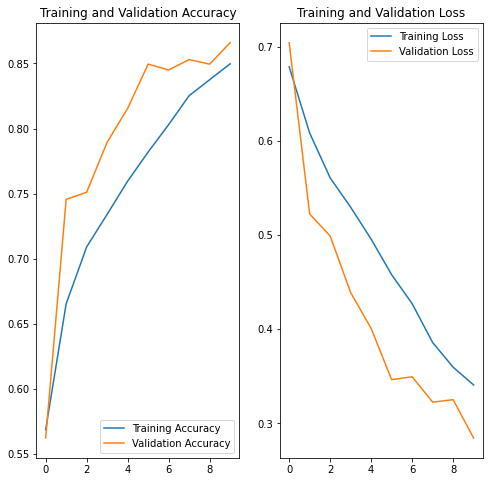

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

##Do simple transfer learning with TensorFlow Hub

In [0]:
image_gen_train = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
IMAGE_RES = 224
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory='../content/Tr',
                                                           shuffle=True,
                                                           target_size=(IMAGE_RES,IMAGE_RES), 
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory='../content/Vl',
                                                              shuffle=False,
                                                              target_size=(IMAGE_RES,IMAGE_RES), 
                                                              class_mode='binary')


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [0]:
import tensorflow_hub as hub
IMAGE_RES = 224
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [28]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [30]:
EPOCHS = 2
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/2
230/230 [==============================] - 77s 335ms/step - loss: 0.0809 - accuracy: 0.9692 - val_loss: 0.0443 - val_accuracy: 0.9855
Epoch 2/2
230/230 [==============================] - 78s 340ms/step - loss: 0.0393 - accuracy: 0.9862 - val_loss: 0.0411 - val_accuracy: 0.9845


In [72]:
!bash -c 'mv ../content/test /content/Test/'

mv: cannot stat '../content/test': No such file or directory


In [87]:
test_generator = test_datagen.flow_from_directory(
        '../content/Test/test/',
        target_size=(IMAGE_RES, IMAGE_RES),
        color_mode="rgb",
        shuffle = False,
        batch_size=BATCH_SIZE)
filenames = test_generator.filenames
nb_samples = len(filenames)


#https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

Found 12500 images belonging to 1 classes.


In [0]:
predict = model.predict_generator(test_generator,steps = nb_samples)

In [89]:
predict

array([[-4.321349 ,  4.6983466],
       [ 4.339056 , -6.3149776],
       [ 2.5034811, -5.3985415],
       ...,
       [-4.627565 ,  1.9237324],
       [ 3.4645789, -5.340908 ],
       [ 3.6234515, -7.1453695]], dtype=float32)